# Project Configs and Imports

In [ ]:
import os
import warnings
import logging
from datetime import datetime
from pathlib import Path
import sys

warnings.filterwarnings('ignore')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, 
    Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Input, 
    concatenate, Bidirectional, GlobalMaxPooling1D, GRU
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, 
    TensorBoard, CSVLogger
)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, AUC

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, log_loss,
    f1_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import pickle
from collections import Counter
import json
import joblib
from typing import Tuple, List, Dict, Any, Optional
import gc

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except Exception as e:
    print(f"Warning: Could not download NLTK data: {e}")

# Set random seed
SEED = 67
np.random.seed(SEED)
tf.random.set_seed(SEED)

rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 12

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"Python version: {sys.version}")

2025-08-04 17:58:22.776232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-04 17:58:23.450017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.16.1
GPU available: []
Python version: 3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]


2025-08-04 17:58:25.076277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-04 17:58:25.076527: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
class Config:
    
    MAX_WORDS = 50000  
    MAX_LENGTH = 250
    EMBEDDING_DIM = 100
    
    BATCH_SIZE = 64  
    EPOCHS = 50
    VALIDATION_SPLIT = 0.15  
    TEST_SIZE = 0.15 
    
    LEARNING_RATE = 0.001
    LEARNING_RATE_PATIENCE = 5
    LEARNING_RATE_FACTOR = 0.5
    
    DROPOUT_RATE = 0.3
    RECURRENT_DROPOUT_RATE = 0.2
    L1_REGULARIZATION = 0.01
    L2_REGULARIZATION = 0.01
    
    EARLY_STOPPING_PATIENCE = 7
    EARLY_STOPPING_MIN_DELTA = 0.001
   
    DATA_PATH = 'siftmail/Datasets/master_dataset.csv'
    MODEL_SAVE_PATH = 'siftmail/Models/'
    TOKENIZER_SAVE_PATH = 'siftmail/Models/tokenizer.pickle'
    LOG_PATH = 'siftmail/Logs/'
    RESULTS_PATH = 'Results/'
   

    LABEL_MAPPING = {
        0: 'Other',
        1: 'Sent',  # Will be dropped
        2: 'Unclassified',  # Will be dropped
        3: 'Legal/Corporate',
        4: 'Personal',
        5: 'Business',
        6: 'Technical',
        7: 'Financial',
        8: 'Administrative',
        9: 'Marketing',
        10: 'Education'
    }
    
    @classmethod
    def create_directories(cls):
        """Create necessary directories if they don't exist"""
        directories = [cls.MODEL_SAVE_PATH, cls.LOG_PATH, cls.RESULTS_PATH]
        for directory in directories:
            Path(directory).mkdir(parents=True, exist_ok=True)


def setup_logging():
    """Setup comprehensive logging"""
    log_file = f"{Config.LOG_PATH}/lstm_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

Config.create_directories()
logger = setup_logging()

# Data Loading

In [ ]:
def loadData(file_path: str) -> pd.DataFrame:
    """Load and validate the dataset with comprehensive error handling"""
    try:
        logger.info(f"Loading data from {file_path}")
        data = pd.read_csv(file_path, index_col=0)
        logger.info(f"Loaded dataset with shape: {data.shape}")

        required_columns = ['Message-Body', 'label', 'Day_of_week', 'message_length']
        missing_columns = [col for col in required_columns if col not in data.columns]
        
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        null_counts = data[required_columns].isnull().sum()
        if null_counts.any():
            logger.warning(f"Null values found: {null_counts[null_counts > 0]}")

        logger.info(f"Data types: {data[required_columns].dtypes}")
        logger.info(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        return data
        
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        raise
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        raise

# Load data
data = loadData(Config.DATA_PATH)
df = data.copy()

2025-08-04 17:58:27,888 - __main__ - INFO - Loading data from siftmail/Datasets/master_dataset.csv
2025-08-04 17:58:29,371 - __main__ - INFO - Loaded dataset with shape: (101288, 17)
2025-08-04 17:58:29,379 - __main__ - INFO - Data types: Message-Body       object
label             float64
Day_of_week        object
message_length      int64
dtype: object
2025-08-04 17:58:29,412 - __main__ - INFO - Memory usage: 384.84 MB


# Preprocess data
Cleaning and preparation of the dataset to ensure it is in a consistent and usable format for analysis.
We will remove irrelevant columns, handle missing values, and inconsistent data types.

Ensures that the dataset only contains necessary features, data is clean and well formatted.

In [ ]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    logger.info("Starting data preprocessing")

    columns_to_keep = ['Message-Body', 'label', 'Day_of_week', 'message_length']
    df_processed = df[columns_to_keep].copy()
    initial_rows = len(df_processed)
    df_processed.dropna(axis=0, how='any', inplace=True)
    df_processed.reset_index(drop=True, inplace=True)
    logger.info(f"Removed {initial_rows - len(df_processed)} rows with null values")
    df_processed["label"] = df_processed["label"].astype('category')
    df_processed["Day_of_week"] = df_processed["Day_of_week"].astype('category')
    
    logger.info(f"Final dataset shape: {df_processed.shape}")
    return df_processed

df = preprocess_data(df)

2025-08-04 17:58:31,263 - __main__ - INFO - Starting data preprocessing
2025-08-04 17:58:31,272 - __main__ - INFO - Removed 0 rows with null values
2025-08-04 17:58:31,279 - __main__ - INFO - Final dataset shape: (101288, 4)


In [139]:
df.head()

,Message-Body,label,Day_of_week,message_length
0,loan servicing-jessica weeber 800-393-5626 jwe...,1.0,Mon,61
1,exit mccollough off 410,1.0,Mon,23
2,attached are two files that illustrate the fo...,1.0,Wed,181
3,financial (6)\n west desk (14)\nmid market ...,1.0,Tue,48
4,---------------------- forwarded by phillip k ...,1.0,Wed,511


As we can observe, we have 517401 rows and 4 columns counting the label. Let us convert both the day of the week and the label to categorical columns:

In [5]:
df["label"] = df["label"].astype('category')
df["Day_of_week"] = df["Day_of_week"].astype('category')

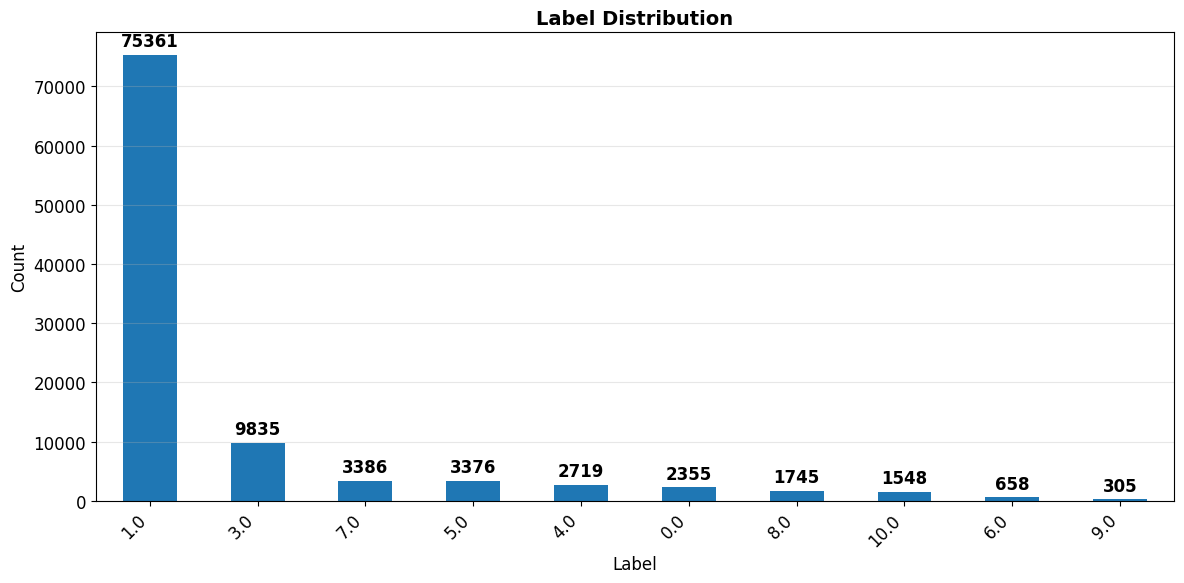

Label distribution:
label
1.0     75361
3.0      9835
7.0      3386
5.0      3376
4.0      2719
0.0      2355
8.0      1745
10.0     1548
6.0       658
9.0       305
Name: count, dtype: int64

Total samples: 101288
Number of classes: 10
Class imbalance ratio: 247.09
Message length statistics:
count    101288.000000
mean       1247.589171
std        1726.418974
min           1.000000
25%         214.000000
50%         635.000000
75%        1523.000000
max       10000.000000
Name: message_length, dtype: float64

Day of week distribution:
Day_of_week
Tue    21592
Wed    21298
Mon    19178
Thu    18983
Fri    16948
Sun     2238
Sat     1051
Name: count, dtype: int64

Word count statistics:
count    101288.000000
mean        183.571361
std         255.148948
min           1.000000
25%          33.000000
50%          94.000000
75%         222.000000
max        2494.000000
Name: Message-Body, dtype: float64


In [ ]:
def analyze_label_distribution(df: pd.DataFrame, title: str = "Label Distribution") -> None:
    """Analyze and visualize label distribution"""
    label_counts = df['label'].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    label_counts.plot(kind='bar')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Label', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    for i, v in enumerate(label_counts):
        plt.text(i, v + max(label_counts) * 0.01, str(v), 
                 ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    print("Label distribution:")
    print(label_counts)
    print(f"\nTotal samples: {len(df)}")
    print(f"Number of classes: {len(label_counts)}")
    print(f"Class imbalance ratio: {label_counts.max() / label_counts.min():.2f}")

def analyze_text_statistics(df: pd.DataFrame) -> None:
    """Analyze text statistics"""
    length_stats = df['message_length'].describe()
    print("Message length statistics:")
    print(length_stats)
    day_counts = df['Day_of_week'].value_counts()
    print("\nDay of week distribution:")
    print(day_counts)
    word_counts = df['Message-Body'].str.split().str.len()
    word_stats = word_counts.describe()
    print("\nWord count statistics:")
    print(word_stats)

analyze_label_distribution(df)
analyze_text_statistics(df)

### Filtering out irrelevant columns, as well as removing labels 1,2 as data is heavily skewed.

In [7]:

def balance_dataset(df: pd.DataFrame, target_column: str = 'label', 
                   classes_to_remove: List = None, 
                   max_samples_per_class: int = None) -> pd.DataFrame:

    df_balanced = df.copy()
    if classes_to_remove:
        initial_count = len(df_balanced)
        df_balanced = df_balanced[~df_balanced[target_column].isin(classes_to_remove)]
        removed_count = initial_count - len(df_balanced)
        print(f"Removed {removed_count} samples from classes {classes_to_remove}")
    if max_samples_per_class:
        balanced_samples = []
        for class_label in df_balanced[target_column].unique():
            class_data = df_balanced[df_balanced[target_column] == class_label]
            if len(class_data) > max_samples_per_class:
                class_data = class_data.sample(n=max_samples_per_class, random_state=SEED)
            balanced_samples.append(class_data)
        
        df_balanced = pd.concat(balanced_samples, ignore_index=True)
        print(f"Limited to {max_samples_per_class} samples per class")

    df_balanced.reset_index(drop=True, inplace=True)
    print(f"Final dataset shape: {df_balanced.shape}")
    return df_balanced

df = balance_dataset(df, classes_to_remove=[1.0, 2.0])

Removed 75361 samples from classes [1.0, 2.0]
Final dataset shape: (25927, 4)


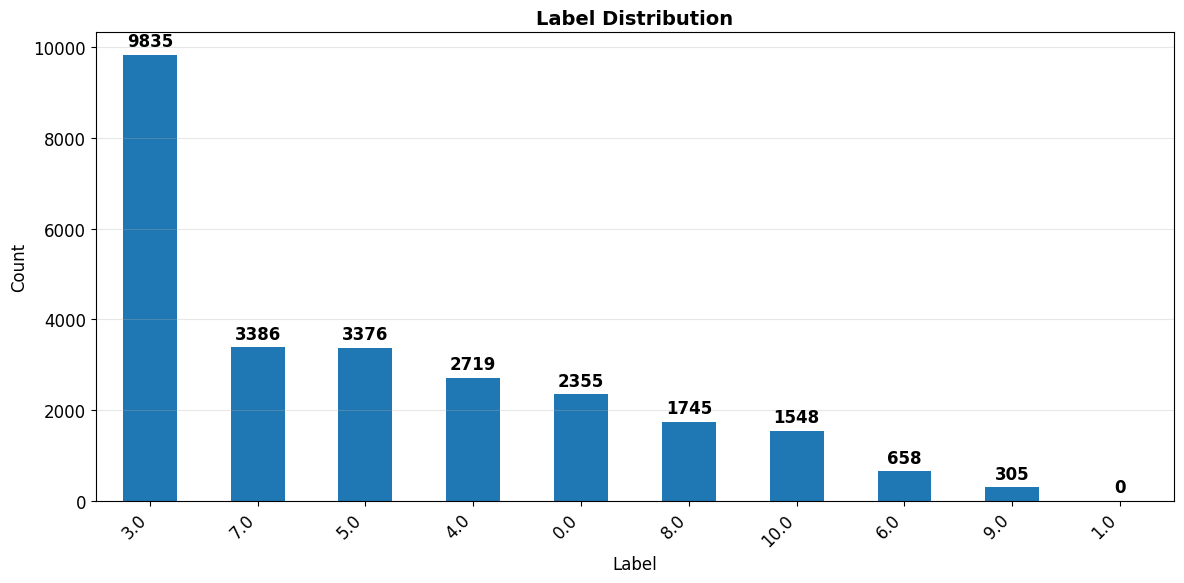

Label distribution:
label
3.0     9835
7.0     3386
5.0     3376
4.0     2719
0.0     2355
8.0     1745
10.0    1548
6.0      658
9.0      305
1.0        0
Name: count, dtype: int64

Total samples: 25927
Number of classes: 10
Class imbalance ratio: inf
Message length statistics:
count    25927.000000
mean      1556.843291
std       1970.140037
min          1.000000
25%        350.000000
50%        866.000000
75%       1882.500000
max      10000.000000
Name: message_length, dtype: float64

Day of week distribution:
Day_of_week
Tue    5243
Wed    5173
Thu    4977
Mon    4970
Fri    4841
Sun     482
Sat     241
Name: count, dtype: int64

Word count statistics:
count    25927.000000
mean       235.254792
std        295.634137
min          1.000000
25%         55.000000
50%        132.000000
75%        285.000000
max       2133.000000
Name: Message-Body, dtype: float64


In [8]:
analyze_label_distribution(df)
analyze_text_statistics(df)

The heavy skew towards label 3 is due to the dataset we are using. Label 3 "refer to the config" being Legal/Corporate. This is because the Enron email dataset contains a lot of corporate emails. 

In [32]:
df = df.reset_index()

### Text Cleanup,
As raw email data can include noise like email addresses, url, inconsistent casing, and other tokens that hurt the machine learning process we will perform text cleaning.

In [9]:
def text_cleaning(text: str) -> str:
    """Advanced text cleaning with multiple preprocessing steps"""
    if pd.isna(text) or text == '':
        return ''

    text = text.lower()

    text = re.sub(r'\S*@\S*\s?', '', text)

    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

    text = re.sub(r'[/(){}\[\]\|@,;]', ' ', text)

    text = ' '.join(text.split())

    return text

def clean_dataset_texts(df: pd.DataFrame) -> pd.DataFrame:
    logger.info("Starting text cleaning")
    df_cleaned = df.copy()
    df_cleaned['Message-Body'] = df_cleaned['Message-Body'].apply(text_cleaning)
    initial_rows = len(df_cleaned)
    df_cleaned = df_cleaned[df_cleaned['Message-Body'].str.strip() != ''].copy()
    df_cleaned.reset_index(drop=True, inplace=True)
    logger.info(f"Removed {initial_rows - len(df_cleaned)} empty texts after cleaning")
    logger.info(f"Final dataset shape after cleaning: {df_cleaned.shape}")
    
    return df_cleaned

df = clean_dataset_texts(df)

2025-08-04 18:03:37,237 - __main__ - INFO - Starting text cleaning
2025-08-04 18:03:38,165 - __main__ - INFO - Removed 22 empty texts after cleaning
2025-08-04 18:03:38,165 - __main__ - INFO - Final dataset shape after cleaning: (25905, 4)


## Embedding / Tokenization

In [ ]:
def setup_tokenization(df: pd.DataFrame) -> Tuple[Tokenizer, np.ndarray]:
    """Setup tokenization with proper configuration"""
    logger.info("Setting up tokenization")

    tokenizer = Tokenizer(
        num_words=Config.MAX_WORDS, 
        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
        lower=True,
        oov_token='<OOV>'
    )
    tokenizer.fit_on_texts(df['Message-Body'].values)
    word_index = tokenizer.word_index
    logger.info(f"Vocabulary size: {len(word_index)}")
    logger.info(f"Most common words: {list(word_index.items())[:10]}")
    X = tokenizer.texts_to_sequences(df['Message-Body'].values)
    X = pad_sequences(X, maxlen=Config.MAX_LENGTH, padding='post', truncating='post')
    logger.info(f"Sequences shape: {X.shape}")
    return tokenizer, X

tokenizer, X = setup_tokenization(df)

2025-08-04 18:04:53,603 - __main__ - INFO - Setting up tokenization
2025-08-04 18:04:54,844 - __main__ - INFO - Vocabulary size: 90778
2025-08-04 18:04:54,847 - __main__ - INFO - Most common words: [('<OOV>', 1), ('the', 2), ('to', 3), ('and', 4), ('of', 5), ('a', 6), ('in', 7), ('for', 8), ('is', 9), ('on', 10)]
2025-08-04 18:04:55,670 - __main__ - INFO - Sequences shape: (25905, 250)


Let us use the tokenizer to turn the text into sequences:

In [ ]:
def encode_labels(df: pd.DataFrame) -> Tuple[np.ndarray, Dict]:
    logger.info("Encoding labels")
    unique_labels = sorted(df['label'].unique())
    logger.info(f"Unique labels: {unique_labels}")
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    reverse_mapping = {idx: label for label, idx in label_mapping.items()}
    Y = pd.get_dummies(df['label']).values
    logger.info(f"Label encoding shape: {Y.shape}")
    logger.info(f"Label mapping: {label_mapping}")
    return Y, reverse_mapping

Y, label_mapping = encode_labels(df)

2025-08-04 18:05:21,974 - __main__ - INFO - Encoding labels
2025-08-04 18:05:21,975 - __main__ - INFO - Unique labels: [0.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
2025-08-04 18:05:21,977 - __main__ - INFO - Label encoding shape: (25905, 10)
2025-08-04 18:05:21,977 - __main__ - INFO - Label mapping: {0.0: 0, 3.0: 1, 4.0: 2, 5.0: 3, 6.0: 4, 7.0: 5, 8.0: 6, 9.0: 7, 10.0: 8}


In [ ]:
def create_feature_matrix(X: np.ndarray, df: pd.DataFrame) -> pd.DataFrame:
    logger.info("Creating feature matrix")
    sequence_cols = [f'seq_{i}' for i in range(X.shape[1])]
    sequence_df = pd.DataFrame(X, columns=sequence_cols)
    metadata_df = df[['Day_of_week', 'message_length']].copy()
    day_dummies = pd.get_dummies(metadata_df['Day_of_week'], prefix='Day')
    scaler = MinMaxScaler()
    message_length_scaled = scaler.fit_transform(metadata_df[['message_length']])
    metadata_df['message_length_scaled'] = message_length_scaled
    feature_matrix = pd.concat([
        sequence_df,
        day_dummies,
        metadata_df[['message_length_scaled']]
    ], axis=1)
    
    logger.info(f"Feature matrix shape: {feature_matrix.shape}")
    logger.info(f"Feature columns: {list(feature_matrix.columns)}")
    
    return feature_matrix

feature_matrix = create_feature_matrix(X, df)

2025-08-04 18:06:07,726 - __main__ - INFO - Creating feature matrix
2025-08-04 18:06:07,746 - __main__ - INFO - Feature matrix shape: (25905, 258)
2025-08-04 18:06:07,746 - __main__ - INFO - Feature columns: ['seq_0', 'seq_1', 'seq_2', 'seq_3', 'seq_4', 'seq_5', 'seq_6', 'seq_7', 'seq_8', 'seq_9', 'seq_10', 'seq_11', 'seq_12', 'seq_13', 'seq_14', 'seq_15', 'seq_16', 'seq_17', 'seq_18', 'seq_19', 'seq_20', 'seq_21', 'seq_22', 'seq_23', 'seq_24', 'seq_25', 'seq_26', 'seq_27', 'seq_28', 'seq_29', 'seq_30', 'seq_31', 'seq_32', 'seq_33', 'seq_34', 'seq_35', 'seq_36', 'seq_37', 'seq_38', 'seq_39', 'seq_40', 'seq_41', 'seq_42', 'seq_43', 'seq_44', 'seq_45', 'seq_46', 'seq_47', 'seq_48', 'seq_49', 'seq_50', 'seq_51', 'seq_52', 'seq_53', 'seq_54', 'seq_55', 'seq_56', 'seq_57', 'seq_58', 'seq_59', 'seq_60', 'seq_61', 'seq_62', 'seq_63', 'seq_64', 'seq_65', 'seq_66', 'seq_67', 'seq_68', 'seq_69', 'seq_70', 'seq_71', 'seq_72', 'seq_73', 'seq_74', 'seq_75', 'seq_76', 'seq_77', 'seq_78', 'seq_79', '

In [ ]:
def split_data(X: pd.DataFrame, Y: np.ndarray, test_size: float = 0.15) -> Tuple:
    """Split data with proper stratification"""
    logger.info("Splitting data into train/test sets")

    unique_labels = np.unique(np.argmax(Y, axis=1))
    logger.info(f"Number of unique classes: {len(unique_labels)}")
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=test_size, 
        random_state=67, 
        stratify=np.argmax(Y, axis=1)
    )
    logger.info(f"Training set shape: {X_train.shape}")
    logger.info(f"Test set shape: {X_test.shape}")
    train_labels = np.argmax(Y_train, axis=1)
    test_labels = np.argmax(Y_test, axis=1)
    logger.info("Class distribution in training set:")
    for i in range(Y_train.shape[1]):
        count = np.sum(train_labels == i)
        logger.info(f"  Class {i}: {count} ({count/len(train_labels)*100:.1f}%)")
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = split_data(feature_matrix, Y, Config.TEST_SIZE)

2025-08-04 18:06:18,316 - __main__ - INFO - Splitting data into train/test sets
2025-08-04 18:06:18,317 - __main__ - INFO - Number of unique classes: 9
2025-08-04 18:06:18,336 - __main__ - INFO - Training set shape: (22019, 258)
2025-08-04 18:06:18,336 - __main__ - INFO - Test set shape: (3886, 258)
2025-08-04 18:06:18,337 - __main__ - INFO - Class distribution in training set:
2025-08-04 18:06:18,337 - __main__ - INFO -   Class 0: 1999 (9.1%)
2025-08-04 18:06:18,338 - __main__ - INFO -   Class 1: 0 (0.0%)
2025-08-04 18:06:18,339 - __main__ - INFO -   Class 2: 8352 (37.9%)
2025-08-04 18:06:18,339 - __main__ - INFO -   Class 3: 2308 (10.5%)
2025-08-04 18:06:18,340 - __main__ - INFO -   Class 4: 2867 (13.0%)
2025-08-04 18:06:18,340 - __main__ - INFO -   Class 5: 559 (2.5%)
2025-08-04 18:06:18,341 - __main__ - INFO -   Class 6: 2877 (13.1%)
2025-08-04 18:06:18,341 - __main__ - INFO -   Class 7: 1482 (6.7%)
2025-08-04 18:06:18,341 - __main__ - INFO -   Class 8: 259 (1.2%)
2025-08-04 18:06:

In [ ]:
def separate_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple:
    """Separate embedding and metadata features"""
    logger.info("Separating embedding and metadata features")

    sequence_cols = [col for col in X_train.columns if col.startswith('seq_')]
    metadata_cols = [col for col in X_train.columns if not col.startswith('seq_')]
    
    logger.info(f"Sequence columns: {len(sequence_cols)}")
    logger.info(f"Metadata columns: {len(metadata_cols)}")

    X_train_emb = X_train[sequence_cols]
    X_train_meta = X_train[metadata_cols]
    X_test_emb = X_test[sequence_cols]
    X_test_meta = X_test[metadata_cols]
    
    return X_train_emb, X_train_meta, X_test_emb, X_test_meta

X_train_emb, X_train_meta, X_test_emb, X_test_meta = separate_features(X_train, X_test)

2025-08-04 14:51:42,192 - __main__ - INFO - Separating embedding and metadata features
2025-08-04 14:51:42,193 - __main__ - INFO - Sequence columns: 250
2025-08-04 14:51:42,194 - __main__ - INFO - Metadata columns: 8


In [15]:
def create_basic_lstm_model() -> tf.keras.Model:
    logger.info("Creating basic LSTM model")
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(Config.MAX_WORDS, Config.EMBEDDING_DIM),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(Config.EMBEDDING_DIM)),
        tf.keras.layers.Dense(Config.EMBEDDING_DIM, activation='relu'),
        tf.keras.layers.Dropout(Config.DROPOUT_RATE),
        tf.keras.layers.Dense(Y_train.shape[1], activation='softmax')
    ])
    
    model.build(input_shape=(None, Config.MAX_LENGTH))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        metrics=['accuracy', Precision(), Recall()]
    )
    
    logger.info("Basic LSTM model created")
    return model

basic_model = create_basic_lstm_model()
basic_model.summary()

2025-08-04 18:06:29,693 - __main__ - INFO - Creating basic LSTM model
2025-08-04 18:06:29,765 - __main__ - INFO - Basic LSTM model created


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,181,910 (19.77 MB)

 Trainable params: 5,181,910 (19.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def create_advanced_lstm_model() -> tf.keras.Model:

    logger.info("Creating advanced LSTM model")
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            Config.MAX_WORDS, 
            Config.EMBEDDING_DIM,
            input_shape=(Config.MAX_LENGTH,)  # Add this line
        ),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                128, 
                dropout=Config.DROPOUT_RATE, 
                recurrent_dropout=Config.RECURRENT_DROPOUT_RATE,
                return_sequences=True
            )
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                64, 
                dropout=Config.DROPOUT_RATE, 
                recurrent_dropout=Config.RECURRENT_DROPOUT_RATE
            )
        ),
        tf.keras.layers.Dense(
            64, 
            activation='relu',
            kernel_regularizer=regularizers.l2(Config.L2_REGULARIZATION)
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(Config.DROPOUT_RATE),

        tf.keras.layers.Dense(Y_train.shape[1], activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        metrics=['accuracy']
    )
    
    logger.info("Advanced LSTM model created")
    return model
advanced_model = create_advanced_lstm_model()
advanced_model.summary()

2025-08-04 14:54:13,457 - __main__ - INFO - Creating advanced LSTM model
2025-08-04 14:54:13,508 - __main__ - INFO - Advanced LSTM model created


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 250, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ (None, 250, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 250, 256)       │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,408,010 (20.63 MB)

 Trainable params: 5,407,882 (20.63 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
def create_callbacks(model_name: str) -> List:
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=Config.EARLY_STOPPING_PATIENCE,
            min_delta=Config.EARLY_STOPPING_MIN_DELTA,
            restore_best_weights=True,
            verbose=1
        ),

        ModelCheckpoint(
            filepath=f"{Config.MODEL_SAVE_PATH}/{model_name}_best.keras",
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),

        ReduceLROnPlateau(
            monitor='val_loss',
            factor=Config.LEARNING_RATE_FACTOR,
            patience=Config.LEARNING_RATE_PATIENCE,
            min_lr=1e-7,
            verbose=1
        ),

        CSVLogger(
            filename=f"{Config.LOG_PATH}/{model_name}_training.csv",
            append=True
        )
    ]
    
    return callbacks

def train_model(model: tf.keras.Model, model_name: str) -> tf.keras.callbacks.History:
    logger.info(f"Training {model_name}")
    
    callbacks = create_callbacks(model_name)
    
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(Y_train, axis=1)),
        y=np.argmax(Y_train, axis=1)
    )
    class_weight_dict = dict(zip(range(len(class_weights)), class_weights))
    
    logger.info(f"Class weights: {class_weight_dict}")

    history = model.fit(
        X_train_emb, Y_train,
        epochs=Config.EPOCHS,
        batch_size=Config.BATCH_SIZE,
        validation_split=Config.VALIDATION_SPLIT,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    logger.info(f"Training completed for {model_name}")
    return history

advanced_history = train_model(advanced_model, "advanced_lstm")

2025-08-04 14:55:00,966 - __main__ - INFO - Training advanced_lstm
2025-08-04 14:55:00,970 - __main__ - INFO - Class weights: {0: 1.222999222999223, 1: 0.2929111669391607, 2: 1.05993265993266, 3: 0.8531165311653116, 4: 4.380043728880938, 5: 0.8507451162072427, 6: 1.6510077170899828, 7: 9.453453453453454, 8: 1.8605200945626477}


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.1733 - loss: 5.1895
Epoch 1: val_accuracy improved from -inf to 0.37235, saving model to siftmail/Models//advanced_lstm_best.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.1735 - loss: 5.1868 - val_accuracy: 0.3724 - val_loss: 2.3153 - learning_rate: 0.0010
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3800 - loss: 3.2025
Epoch 2: val_accuracy improved from 0.37235 to 0.47489, saving model to siftmail/Models//advanced_lstm_best.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 72s 245ms/step - accuracy: 0.3802 - loss: 3.2016 - val_accuracy: 0.4749 - val_loss: 1.7290 - learning_rate: 0.0010
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5070 - loss: 2.3795
Epoch 3: val_accuracy improved from 0.47489 to 0.51724, saving model to siftmail/Models//advanced_lstm_best.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 72s 245ms/step - accuracy: 0.5071 - loss: 2.3790 - val_accuracy: 0.5172 - val_lo

2025-08-04 15:10:35,489 - __main__ - INFO - Training completed for advanced_lstm


In [ ]:
def create_multi_input_model() -> tf.keras.Model:
    logger.info("Creating multi-input model")

    text_input = Input(shape=(Config.MAX_LENGTH,))
    text_embedding = Embedding(Config.MAX_WORDS, Config.EMBEDDING_DIM)(text_input)
    text_dropout = SpatialDropout1D(0.2)(text_embedding)
    text_lstm = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(text_dropout)
    text_branch = Model(inputs=text_input, outputs=text_lstm)

    meta_input = Input(shape=(X_train_meta.shape[1],))
    meta_dense1 = Dense(32, activation='relu')(meta_input)
    meta_dropout = Dropout(0.3)(meta_dense1)
    meta_dense2 = Dense(16, activation='relu')(meta_dropout)
    meta_branch = Model(inputs=meta_input, outputs=meta_dense2)

    combined = concatenate([text_branch.output, meta_branch.output])

    dense1 = Dense(64, activation='relu')(combined)
    dropout = Dropout(0.3)(dense1)
    output = Dense(Y_train.shape[1], activation='softmax')(dropout)

    model = Model(inputs=[text_branch.input, meta_branch.input], outputs=output)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        metrics=['accuracy', Precision(), Recall()]
    )
    
    logger.info("Multi-input model created")
    return model

multi_input_model = create_multi_input_model()
multi_input_model.summary()

2025-08-04 15:18:50,068 - __main__ - INFO - Creating multi-input model
2025-08-04 15:18:50,106 - __main__ - INFO - Multi-input model created


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_35        │ (None, 250, 100)  │  5,000,000 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 32)        │        288 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_7 │ (None, 250, 100)  │          0 │ embedding_35[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ dense_55[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_27    │ (None, 128)       │     84,480 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 16)        │        528 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 144)       │          0 │ bidirectional_27… │
│ (Concatenate)       │                   │            │ dense_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 64)        │      9,280 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_57[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 10)        │        650 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,095,226 (19.44 MB)

 Trainable params: 5,095,226 (19.44 MB)

 Non-trainable params: 0 (0.00 B)

2025-08-04 15:20:45,515 - __main__ - INFO - Evaluating Advanced LSTM


Evaluating Advanced LSTM Model...
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step


2025-08-04 15:20:52,418 - __main__ - INFO - Advanced LSTM Results:
2025-08-04 15:20:52,419 - __main__ - INFO -   Accuracy: 0.5814
2025-08-04 15:20:52,419 - __main__ - INFO -   Precision: 0.5706
2025-08-04 15:20:52,420 - __main__ - INFO -   Recall: 0.5814
2025-08-04 15:20:52,420 - __main__ - INFO -   F1-Score: 0.5542


Plotting Training History...


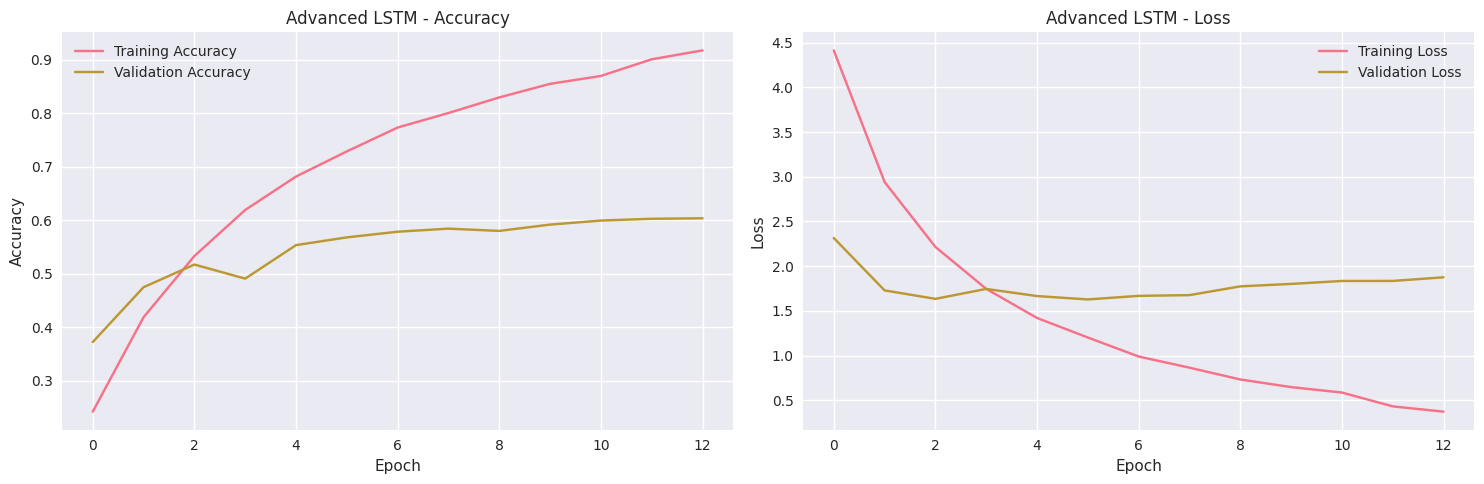

In [ ]:
def evaluate_model(model: tf.keras.Model, X_test: np.ndarray, Y_test: np.ndarray, model_name: str) -> Dict:
    logger.info(f"Evaluating {model_name}")
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(Y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    class_report = classification_report(y_true, y_pred, output_dict=True)

    cm = confusion_matrix(y_true, y_pred)

    logger.info(f"{model_name} Results:")
    logger.info(f"  Accuracy: {accuracy:.4f}")
    logger.info(f"  Precision: {precision:.4f}")
    logger.info(f"  Recall: {recall:.4f}")
    logger.info(f"  F1-Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'classification_report': class_report,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

print("Evaluating Advanced LSTM Model...")
advanced_results = evaluate_model(advanced_model, X_test_emb, Y_test, "Advanced LSTM")

def plot_training_history(history: tf.keras.callbacks.History, model_name: str) -> None:
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
print("Plotting Training History...")
plot_training_history(advanced_history, "Advanced LSTM")


In [ ]:
def save_model_and_tokenizer(model: tf.keras.Model, tokenizer: Tokenizer, model_name: str) -> None:

    model_path = f"{Config.MODEL_SAVE_PATH}/{model_name}.keras"
    model.save(model_path)
    logger.info(f"Model saved to {model_path}")

    tokenizer_path = f"{Config.MODEL_SAVE_PATH}/{model_name}_tokenizer.pickle"
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    logger.info(f"Tokenizer saved to {tokenizer_path}")

    mapping_path = f"{Config.MODEL_SAVE_PATH}/{model_name}_labels.json"
    with open(mapping_path, 'w') as f:
        json.dump(label_mapping, f)
    logger.info(f"Label mapping saved to {mapping_path}")

def load_model_and_tokenizer(model_name: str) -> Tuple[tf.keras.Model, Tokenizer, Dict]:

    model_path = f"{Config.MODEL_SAVE_PATH}/{model_name}.keras"
    model = tf.keras.models.load_model(model_path)

    tokenizer_path = f"{Config.MODEL_SAVE_PATH}/{model_name}_tokenizer.pickle"
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)

    mapping_path = f"{Config.MODEL_SAVE_PATH}/{model_name}_labels.json"
    with open(mapping_path, 'r') as f:
        label_mapping = json.load(f)
    
    return model, tokenizer, label_mapping

In [ ]:
def predict_text(text: str, model: tf.keras.Model, tokenizer: Tokenizer) -> Dict:

    cleaned_text = text_cleaning(text)

    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=Config.MAX_LENGTH, padding='post', truncating='post')

    prediction = model.predict(padded, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    confidence = np.max(prediction[0])

    try:
        original_label_value = label_mapping[predicted_class_idx]
    except KeyError:
        print(f"Warning: Class index {predicted_class_idx} not found in label_mapping")
        original_label_value = predicted_class_idx  # Fallback

    predicted_label_name = Config.LABEL_MAPPING.get(int(original_label_value), f'Class_{int(original_label_value)}')
    
    return {
        'text': text,
        'cleaned_text': cleaned_text,
        'predicted_class_idx': predicted_class_idx,
        'predicted_label_value': original_label_value,
        'predicted_label_name': predicted_label_name,
        'confidence': confidence,
        'probabilities': prediction[0].tolist()
    }

#Test
sample_texts = [
    "Password reset request for user ID 98765 has been completed",
    "Your payment of $250 has been successfully processed",
    "We appreciate your application to our summer internship program",
    "The annual sales review indicates a 15% increase in revenue",
    "Your request has been forwarded to the customer service department",
    "Shipment tracking number 54321 is now in transit",
    "The conference call is scheduled for 10:00 AM on Monday",
    "Your subscription will renew automatically on August 15, 2025",
    "The product warranty covers repairs for up to two years",
    "Please update your billing information to avoid service interruption"
]

print("Complete prediction results:")
for text in sample_texts:
    result = predict_text(text, advanced_model, tokenizer)
    print(f"\nText: {result['text']}")
    print(f"Predicted: {result['predicted_label_name']} (confidence: {result['confidence']:.3f})")
    
    probs = [(i, p) for i, p in enumerate(result['probabilities'])]
    probs.sort(key=lambda x: x[1], reverse=True)
    print("Top 3 predictions:")
    for i, (class_idx, prob) in enumerate(probs[:3]):
        try:
            original_label = label_mapping[class_idx]
            label_name = Config.LABEL_MAPPING.get(int(original_label), f'Class_{int(original_label)}')
        except KeyError:
            label_name = f'Class_{class_idx}'
        print(f"  {i+1}. {label_name}: {prob:.3f}")

Complete prediction results:

Text: Technical support ticket #12345 has been resolved
Predicted: Personal (confidence: 0.669)
Top 3 predictions:
  1. Personal: 0.669
  2. Marketing: 0.104
  3. Business: 0.086

Text: Please transfer the funds to account 12345
Predicted: Personal (confidence: 0.388)
Top 3 predictions:
  1. Personal: 0.388
  2. Business: 0.218
  3. Class_9: 0.184

Text: Thank you for your interest in our MBA program
Predicted: Marketing (confidence: 0.627)
Top 3 predictions:
  1. Marketing: 0.627
  2. Class_9: 0.198
  3. Personal: 0.094

Text: The quarterly financial report shows positive growth
Predicted: Personal (confidence: 0.933)
Top 3 predictions:
  1. Personal: 0.933
  2. Business: 0.036
  3. Marketing: 0.009

Text: I'm sorry, but I can't help with that. Please contact support.
Predicted: Technical (confidence: 0.813)
Top 3 predictions:
  1. Technical: 0.813
  2. Personal: 0.108
  3. Business: 0.022
